# VIT  - RKD + QLORA
## Amaan Mithani Kunaal Vadgama
#NYU

In [16]:
from huggingface_hub import notebook_login

notebook_login()

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Run install

In [17]:
!pip install datasets evaluate

In [18]:
!pip install accelerate -U

In [19]:
from transformers import ViTForImageClassification, MobileNetV2Config, MobileNetV2ForImageClassification
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments
from datasets import load_dataset
import torch
import evaluate
import numpy as np

In [20]:
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")


Number of GPUs available: 1
GPU 0: Tesla T4


# Run data + models

In [8]:
processor = AutoImageProcessor.from_pretrained("merve/beans-vit-224")
model = AutoModelForImageClassification.from_pretrained("merve/beans-vit-224")

In [9]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [21]:
class CustomViTModel(ViTForImageClassification):
    def __init__(self, original_model,k):
        super(CustomViTModel, self).__init__(original_model.config)

        self.vit.embeddings = original_model.vit.embeddings
        self.vit.encoder.layer = nn.ModuleList(
            [original_model.vit.encoder.layer[i] for i in range(k)]
        )

        self.classifier = original_model.classifier

original_model = ViTForImageClassification.from_pretrained("merve/beans-vit-224")
student_model = CustomViTModel(original_model,6)

In [22]:
dataset = load_dataset("beans")

In [23]:
from transformers import AutoImageProcessor
teacher_processor = AutoImageProcessor.from_pretrained("merve/beans-vit-224")
dataset = load_dataset("beans")

def process(examples):
    processed_inputs = teacher_processor(examples["image"])
    return processed_inputs

processed_datasets = dataset.map(process, batched=True)

In [4]:
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F


class ImageDistilTrainer(Trainer):

    def __init__(self, teacher_model=None, student_model=None, temperature=1.0, lambda_param=0.5, *args, **kwargs):
        if student_model is None:
            raise ValueError("Student model must be provided for distillation")

        super().__init__(model=student_model, *args, **kwargs)

        self.teacher = teacher_model
        self.student = student_model
        self.loss_function = nn.KLDivLoss(reduction="batchmean")
        self.temperature = temperature
        self.lambda_param = lambda_param

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.teacher.to(device)
        self.teacher.eval()


    def compute_loss(self, student, inputs, return_outputs=False, **kwargs):

        student_output = self.student(**inputs)

        with torch.no_grad():
          teacher_output = self.teacher(**inputs)

        soft_teacher = F.softmax(teacher_output.logits / self.temperature, dim=-1)
        soft_student = F.log_softmax(student_output.logits / self.temperature, dim=-1)

        distillation_loss = self.loss_function(soft_student, soft_teacher) * (self.temperature ** 2)

        student_target_loss = student_output.loss

        loss = (1. - self.lambda_param) * student_target_loss + self.lambda_param * distillation_loss
        return (loss, student_output) if return_outputs else loss

In [24]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    acc = accuracy.compute(references=labels, predictions=np.argmax(predictions, axis=1))
    return {"accuracy": acc["accuracy"]}

In [25]:
import evaluate
import numpy as np
from transformers import DefaultDataCollator

num_labels = len(processed_datasets["train"].features["labels"].names)
accuracy = evaluate.load("accuracy")
data_collator = DefaultDataCollator()

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    acc = accuracy.compute(references=labels, predictions=np.argmax(predictions, axis=1))
    return {"accuracy": acc["accuracy"]}

In [26]:
import torch.nn.init as init

def reinitialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d):
            init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
            if layer.bias is not None:
                init.constant_(layer.bias, 0)
        elif isinstance(layer, nn.Linear):
            init.xavier_normal_(layer.weight)
            init.constant_(layer.bias, 0)
        elif isinstance(layer, nn.LayerNorm):
            init.constant_(layer.weight, 1)
            init.constant_(layer.bias, 0)


# Raw Accuracies and parameters count

In [16]:
model_9 = CustomViTModel(original_model,9)
model_6 = CustomViTModel(original_model,6)
model_3 = CustomViTModel(original_model,3)

accuracy = evaluate.load("accuracy")

In [17]:
trainer = Trainer(
    model=model_9,
    compute_metrics=compute_metrics
)

acc = trainer.evaluate(processed_datasets["test"])['eval_accuracy']
print(acc)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kv007 (kv007-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


0.734375


In [18]:
trainer = Trainer(
    model=model_6,
    compute_metrics=compute_metrics
)

# Evaluate the model
acc = trainer.evaluate(processed_datasets["test"])['eval_accuracy']
print(acc)

0.34375


In [19]:
trainer = Trainer(
    model=model_3,
    compute_metrics=compute_metrics
)

# Evaluate the model
acc = trainer.evaluate(processed_datasets["test"])['eval_accuracy']
print(acc)

0.328125


In [20]:


from transformers import ViTForImageClassification

# Load the teacher model
teacher_model = ViTForImageClassification.from_pretrained("merve/beans-vit-224")

# Function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count parameters
num_parameters_teacher = count_parameters(teacher_model)
num_parameters_9 = count_parameters(model_9)
num_parameters_6 = count_parameters(model_6)
num_parameters_3 = count_parameters(model_3)

# Print results
print(num_parameters_teacher, num_parameters_9, num_parameters_6, num_parameters_3)


85800963 64537347 43273731 22010115


# HP tuning for Lambda and Temperature with WANDB

In [ ]:
!pip install wandb
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
# method
sweep_config = {
    'method': 'random'
}

parameters_dict = {
    'temperature':{
        'values':[1,3,5]
    },
    'lambda_param':{
        'values':[0.2,0.5,0.8]
    }
}

sweep_config['parameters'] = parameters_dict


In [ ]:
def train():
    training_args = TrainingArguments(
        output_dir="vit",
        num_train_epochs=3,
        fp16=True,
        logging_dir="vit/logs",
        logging_strategy="epoch",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        run_name="vit-6",
        logging_steps=1,
        report_to="none",  # Disable W&B reporting
    )

    trainer = ImageDistilTrainer(
        student_model=student_model_6,
        teacher_model=teacher_model,
        args=training_args,
        train_dataset=processed_datasets["train"],
        eval_dataset=processed_datasets["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        temperature=1,
        lambda_param=0.5,
    )

    trainer.train()


In [ ]:
def train_with_params(temp, lamb):
    training_args = TrainingArguments(
        output_dir=f"vit_t{temp}_l{lamb}",
        num_train_epochs=3,
        fp16=True,
        logging_dir=f"vit/logs_t{temp}_l{lamb}",
        logging_strategy="epoch",  #  still works, despite the warning
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        run_name=f"vit-temp{temp}-lambda{lamb}",
        logging_steps=1,
        report_to="none",
    )

    trainer = ImageDistilTrainer(
        student_model=student_model,
        teacher_model=teacher_model,
        args=training_args,
        train_dataset=processed_datasets["train"],
        eval_dataset=processed_datasets["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        temperature=temp,
        lambda_param=lamb,
    )

    trainer.train()


In [ ]:
# wandb.agent(sweep_id, train, count=5)
train()



Epoch,Training Loss,Validation Loss,Accuracy
1,0.221400,0.110509,1.000000
2,0.113900,0.107993,0.984962
3,0.103100,0.101295,0.984962


 Best temperature 3, lambda 0.2

In [ ]:
# metrics = trainer.evaluate()
# print("Test set accuracy:", metrics['eval_accuracy'])
from transformers import TrainingArguments

# Define the same training args (adjust paths if needed)
training_args = TrainingArguments(
    output_dir="vit_t1_l0.2",  # or whatever your actual output_dir was
    per_device_eval_batch_size=32,
    report_to="none",
)

# Recreate the trainer with only evaluation needs
trainer = ImageDistilTrainer(
    student_model=student_model,  # or load from saved path
    teacher_model=teacher_model,
    args=training_args,
    eval_dataset=processed_datasets["validation"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    temperature=1,
    lambda_param=0.2
)

# Evaluate
metrics = trainer.evaluate()
print("Test set accuracy:", metrics['eval_accuracy'])


Test set accuracy: 0.3308270676691729


# Train optimal WB HP

In [ ]:

student_model_6 = CustomViTModel(teacher_model, 6)
reinitialize_weights(student_model_6)

# Step 1: Define distillation parameters
temperature = 3
lambda_param = 0.2

# Step 2: Set up TrainingArguments (disable wandb with report_to='none')
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="distil_12_6_HP",
    num_train_epochs=3,
    fp16=True,
    logging_dir="vit/logs_t3_l0.2",  # you can change this for different configs
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"  #  disables wandb and external logging
)

# Step 3: Train using your custom ImageDistilTrainer
trainer = ImageDistilTrainer(
    student_model=student_model_6,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    temperature=temperature,
    lambda_param=lambda_param,
)

# Step 4: Train the model
trainer.train()

# Step 5: Evaluate the trained model on test data
metrics = trainer.evaluate(processed_datasets["test"])
print("Test Set Accuracy:", metrics["eval_accuracy"])


Epoch,Training Loss,Validation Loss,Accuracy
1,1.251100,0.836360,0.578947
2,0.667700,0.620210,0.721805
3,0.540000,0.522996,0.781955


Test Set Accuracy: 0.8515625


In [ ]:


from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

# Step 1: Load the teacher model
teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)
teacher_model.eval()

# Step 2: Define wandb-free training arguments
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_eval_batch_size=32,
    report_to="none",  # disable wandb/logging
)

# Step 3: Set up the trainer
trainer = Trainer(
    model=teacher_model,
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Step 4: Evaluate on test set
metrics = trainer.evaluate(eval_dataset=processed_datasets["test"])
print("Teacher Model Test Accuracy:", metrics["eval_accuracy"])


Teacher Model Test Accuracy: 0.9375


# Loop for the 4 training

In [ ]:


def train_and_compare(modelList, temperature, lambda_param, epochs):
    accuracies = []
    direct_accuracy = 0

    # Training args with wandb disabled
    training_args = TrainingArguments(
        output_dir='loop_test',
        num_train_epochs=epochs,
        fp16=True,
        logging_dir=f"{repo_name}/logs",
        logging_strategy="epoch",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="none",  #  Disable wandb and other logging integrations
    )


    ################################## Multistep distillation ###############################
    for k in range(1, len(modelList)):
        print(f"Training step {k}: teacher=model_{k-1} → student=model_{k}")
        intermediary_model = modelList[k]
        intermediary_teacher = modelList[k - 1]

        trainer = ImageDistilTrainer(
            student_model=intermediary_model,
            teacher_model=intermediary_teacher,
            args=training_args,
            train_dataset=processed_datasets["train"],
            eval_dataset=processed_datasets["validation"],
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            temperature=temperature,
            lambda_param=lambda_param,
        )

        trainer.train()
        interm_accuracy = trainer.evaluate(processed_datasets["test"])['eval_accuracy']
        accuracies.append(interm_accuracy)

    return accuracies


In [ ]:
teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True)

student_model_9 = CustomViTModel(teacher_model,9)
student_model_6 = CustomViTModel(teacher_model,6)
student_model_3 = CustomViTModel(teacher_model,3)

modelList = [teacher_model,student_model_9,student_model_6,student_model_3]

In [ ]:
# repo_name = 'test'
# a,b = train_and_compare( modelList,temperature=3,lambda_param=0.2,epochs=10)
repo_name = 'test'
accuracies = train_and_compare(modelList, temperature=3, lambda_param=0.2, epochs=3)


Training step 1: teacher=model_0 → student=model_1


Epoch,Training Loss,Validation Loss,Accuracy
1,0.220500,0.134143,0.992481
2,0.127500,0.127285,1.000000
3,0.119700,0.123589,1.000000


Training step 2: teacher=model_1 → student=model_2


Epoch,Training Loss,Validation Loss,Accuracy
1,0.113700,0.038703,0.992481
2,0.026600,0.051638,0.992481
3,0.023500,0.043753,0.992481


Training step 3: teacher=model_2 → student=model_3


Epoch,Training Loss,Validation Loss,Accuracy
1,0.519300,0.262359,0.924812
2,0.149700,0.099995,0.984962
3,0.087700,0.094718,0.992481


In [ ]:
print(accuracies)

[0.9609375, 0.953125, 0.9609375]


In [ ]:
save_path = "/content/drive/MyDrive/vit_multistep_models"

# Create folders and save each model
teacher_model.save_pretrained(f"{save_path}/teacher_model")
student_model_9.save_pretrained(f"{save_path}/student_model_9")
student_model_6.save_pretrained(f"{save_path}/student_model_6")
student_model_3.save_pretrained(f"{save_path}/student_model_3")


In [ ]:
import pandas as pd

df = pd.DataFrame({
    'step': ['step_1 (9-layer)', 'step_2 (6-layer)', 'step_3 (3-layer)'],
    'accuracy': accuracies
})

df.to_csv(f"{save_path}/distillation_accuracies.csv", index=False)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from transformers import AutoModelForImageClassification
import pandas as pd
import pickle
import os

save_path = "/content/drive/MyDrive/vit_project_all"
os.makedirs(save_path, exist_ok=True)

# Save models
teacher_model.save_pretrained(f"{save_path}/teacher_model")
student_model_9.save_pretrained(f"{save_path}/student_model_9")
student_model_6.save_pretrained(f"{save_path}/student_model_6")
student_model_3.save_pretrained(f"{save_path}/student_model_3")


# Save accuracies as CSV
df = pd.DataFrame({'step': ['step_1', 'step_2', 'step_3'], 'accuracy': accuracies})
df.to_csv(f"{save_path}/distillation_accuracies.csv", index=False)

# Save full session
with open(f"{save_path}/session.pkl", "wb") as f:
    pickle.dump({
        'modelList': modelList,
        'accuracies': accuracies
    }, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True)

student_model_9 = CustomViTModel(teacher_model,9)
student_model_6 = CustomViTModel(teacher_model,6)
student_model_3 = CustomViTModel(teacher_model,3)

reinitialize_weights(student_model_9)
reinitialize_weights(student_model_6)
reinitialize_weights(student_model_3)


modelList = [teacher_model,student_model_9,student_model_6,student_model_3]

In [ ]:
repo_name = 'test'
accuracies_ = train_and_compare(modelList,temperature=3,lambda_param=0.2,epochs=3)

Training step 1: teacher=model_0 → student=model_1


Epoch,Training Loss,Validation Loss,Accuracy
1,0.508800,0.529739,0.751880
2,0.401300,0.471532,0.842105
3,0.319500,0.461435,0.827068


Training step 2: teacher=model_1 → student=model_2


Epoch,Training Loss,Validation Loss,Accuracy
1,0.275500,0.427747,0.804511
2,0.175400,0.403378,0.827068
3,0.114300,0.387342,0.819549


Training step 3: teacher=model_2 → student=model_3


Epoch,Training Loss,Validation Loss,Accuracy
1,0.300700,0.463150,0.774436
2,0.196800,0.452683,0.789474
3,0.156500,0.423488,0.812030


In [ ]:
print(accuracies_)


[0.859375, 0.8359375, 0.8515625]


# Multi agent implementation

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class BI_ImageDistilTrainer(Trainer):
    """
    A custom Hugging Face Trainer that performs knowledge distillation from two teacher models
    to a single student model using a weighted average of KL-divergence losses.
    """

    def __init__(
        self,
        teacher_model_1=None,
        teacher_model_2=None,
        student_model=None,
        temperature=1.0,
        lambda_param=0.5,
        alpha=0.5,
        *args, **kwargs
    ):
        if student_model is None:
            raise ValueError("A student model must be provided.")

        super().__init__(model=student_model, *args, **kwargs)

        self.teacher_1 = teacher_model_1
        self.teacher_2 = teacher_model_2
        self.student = student_model
        self.temperature = temperature
        self.lambda_param = lambda_param
        self.alpha = alpha
        self.loss_function = nn.KLDivLoss(reduction="batchmean")

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.teacher_1.to(device).eval()
        self.teacher_2.to(device).eval()

    def compute_loss(self, student, inputs, return_outputs=False, **kwargs):
        student_output = self.student(**inputs)

        with torch.no_grad():
            teacher_output_1 = self.teacher_1(**inputs)
            teacher_output_2 = self.teacher_2(**inputs)

        # Softened probabilities
        soft_teacher_1 = F.softmax(teacher_output_1.logits / self.temperature, dim=-1)
        soft_teacher_2 = F.softmax(teacher_output_2.logits / self.temperature, dim=-1)
        soft_student = F.log_softmax(student_output.logits / self.temperature, dim=-1)

        # Distillation losses
        loss_1 = self.loss_function(soft_student, soft_teacher_1) * (self.temperature ** 2)
        loss_2 = self.loss_function(soft_student, soft_teacher_2) * (self.temperature ** 2)
        distillation_loss = self.alpha * loss_1 + (1 - self.alpha) * loss_2

        # Student's original loss
        student_target_loss = student_output.loss

        # Final combined loss
        loss = (1. - self.lambda_param) * student_target_loss + self.lambda_param * distillation_loss

        return (loss, student_output) if return_outputs else loss


In [ ]:

from transformers import TrainingArguments

def bi_train_and_compare(modelList, temperature, lambda_param, alpha, epochs):
    accuracies1 = []
    repo_name = 'test'

    #  Updated training arguments (wandb-free and HF 4.46+ compatible)
    training_args = TrainingArguments(
        logging_dir=f"{repo_name}/logs",
        logging_strategy="epoch",
        eval_strategy="epoch",  # replaces deprecated evaluation_strategy
        save_strategy="epoch",
        num_train_epochs=epochs,
        output_dir='loop_test',
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="none"  #  disables wandb/HF Hub logging
    )

    print(len(modelList))
    for k in range(1, len(modelList)):
        print(f'k = {k}')

        if k == 1:
            # First step: single-teacher distillation
            intermediary_model = modelList[k]
            intermediary_teacher = modelList[k - 1]

            trainer = ImageDistilTrainer(
                student_model=intermediary_model,
                teacher_model=intermediary_teacher,
                args=training_args,
                train_dataset=processed_datasets["train"],
                eval_dataset=processed_datasets["validation"],
                data_collator=data_collator,
                compute_metrics=compute_metrics,
                temperature=temperature,
                lambda_param=lambda_param
            )

        else:
            # Later steps: dual-teacher distillation
            intermediary_teacher_1 = modelList[k - 1]
            intermediary_teacher_2 = modelList[k - 2]
            intermediary_student = modelList[k]

            trainer = BI_ImageDistilTrainer(
                student_model=intermediary_student,
                teacher_model_1=intermediary_teacher_1,
                teacher_model_2=intermediary_teacher_2,
                args=training_args,
                train_dataset=processed_datasets["train"],
                eval_dataset=processed_datasets["validation"],
                data_collator=data_collator,
                compute_metrics=compute_metrics,
                temperature=temperature,
                lambda_param=lambda_param,
                alpha=alpha
            )

        trainer.train()
        accuracy = trainer.evaluate(processed_datasets["test"])['eval_accuracy']
        accuracies1.append(accuracy)

    return accuracies1



# With original weights

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True)

student_model_9 = CustomViTModel(teacher_model,9)
student_model_6 = CustomViTModel(teacher_model,6)
student_model_3 = CustomViTModel(teacher_model,3)



modelList = [teacher_model,student_model_9,student_model_6,student_model_3]

In [ ]:
accuracies1 = bi_train_and_compare(modelList,temperature=3,lambda_param=0.2,alpha=0.5,epochs=3)

4
k = 1


Epoch,Training Loss,Validation Loss,Accuracy
1,0.141600,0.161033,0.977444
2,0.135500,0.142379,0.992481
3,0.132800,0.142542,0.992481


k = 2


Epoch,Training Loss,Validation Loss,Accuracy
1,0.160200,0.119220,0.992481
2,0.101300,0.109928,0.992481
3,0.099500,0.110871,0.992481


k = 3


Epoch,Training Loss,Validation Loss,Accuracy
1,0.500300,0.224256,0.932331
2,0.144800,0.097353,0.984962
3,0.073100,0.092959,0.992481


In [ ]:
print(accuracies1)

[0.9609375, 0.953125, 0.9609375]


# With reinitialized weights

In [ ]:

from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True)

student_model_9 = CustomViTModel(teacher_model, 9)
student_model_6 = CustomViTModel(teacher_model, 6)
student_model_3 = CustomViTModel(teacher_model, 3)

reinitialize_weights(student_model_9)
reinitialize_weights(student_model_6)
reinitialize_weights(student_model_3)

modelList = [teacher_model, student_model_9, student_model_6, student_model_3]


In [ ]:
b_bi_re = bi_train_and_compare(modelList, temperature=3, lambda_param=0.2, alpha=0.5, epochs=3)


4
k = 1


Epoch,Training Loss,Validation Loss,Accuracy
1,1.170200,0.648811,0.706767
2,0.672400,0.607619,0.714286
3,0.540500,0.523721,0.819549


k = 2


Epoch,Training Loss,Validation Loss,Accuracy
1,0.625800,0.523104,0.774436
2,0.486100,0.474692,0.804511
3,0.385700,0.444543,0.812030


k = 3


Epoch,Training Loss,Validation Loss,Accuracy
1,0.485000,0.487788,0.804511
2,0.361200,0.470560,0.781955
3,0.280500,0.418693,0.804511


In [ ]:
print(b_bi_re)

[0.7890625, 0.8203125, 0.8203125]


# Straighforward distillation

In [ ]:


repo_name = "test"
num_labels = len(processed_datasets["train"].features["labels"].names)

# Load teacher
teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)

# Define student models
student_model_9 = CustomViTModel(teacher_model, 9)
student_model_6 = CustomViTModel(teacher_model, 6)
student_model_3 = CustomViTModel(teacher_model, 3)

# Reinitialize student weights
reinitialize_weights(student_model_9)
reinitialize_weights(student_model_6)
reinitialize_weights(student_model_3)

# Train student_model_9
print("Training student_model_9")
training_args_9 = TrainingArguments(
    output_dir="loop_test_9",
    logging_dir=f"{repo_name}/logs_9",
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer1 = ImageDistilTrainer(
    student_model=student_model_9,
    teacher_model=teacher_model,
    args=training_args_9,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    temperature=3,
    lambda_param=0.2
)

trainer1.train()
acc1 = trainer1.evaluate(processed_datasets["test"])['eval_accuracy']

# Train student_model_6
print("Training student_model_6")
training_args_6 = TrainingArguments(
    output_dir="loop_test_6",
    logging_dir=f"{repo_name}/logs_6",
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer2 = ImageDistilTrainer(
    student_model=student_model_6,
    teacher_model=teacher_model,
    args=training_args_6,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    temperature=3,
    lambda_param=0.2
)

trainer2.train()
acc2 = trainer2.evaluate(processed_datasets["test"])['eval_accuracy']

# Train student_model_3
print("Training student_model_3")
training_args_3 = TrainingArguments(
    output_dir="loop_test_3",
    logging_dir=f"{repo_name}/logs_3",
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer3 = ImageDistilTrainer(
    student_model=student_model_3,
    teacher_model=teacher_model,
    args=training_args_3,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    temperature=3,
    lambda_param=0.2
)

trainer3.train()
acc3 = trainer3.evaluate(processed_datasets["test"])['eval_accuracy']

# Print results
acc = [acc1, acc2, acc3]
print('Straightforward Distillation Accuracies (9L, 6L, 3L):', acc)


Training student_model_9


Epoch,Training Loss,Validation Loss,Accuracy
1,1.178100,0.905067,0.503759
2,0.662900,0.613811,0.729323
3,0.526100,0.525812,0.789474


Training student_model_6


Epoch,Training Loss,Validation Loss,Accuracy
1,0.656900,0.574096,0.759398
2,0.519100,0.513580,0.804511
3,0.430400,0.473990,0.827068


Training student_model_3


Epoch,Training Loss,Validation Loss,Accuracy
1,0.597700,0.520489,0.789474
2,0.445900,0.489483,0.857143
3,0.367600,0.464241,0.849624


Straightforward Distillation Accuracies (9L, 6L, 3L): [0.8359375, 0.828125, 0.859375]


# Multi Agent KD - 3 models to the smaller


In [ ]:


class tri_ImageDistilTrainer(Trainer):
    def __init__(
        self,
        teacher_model_1=None,
        teacher_model_2=None,
        teacher_model_3=None,
        student_model=None,
        temperature=1.0,
        lambda_param=0.5,
        betas=[1/3, 1/3, 1/3],
        *args, **kwargs
    ):
        super().__init__(model=student_model, *args, **kwargs)

        self.teacher_1 = teacher_model_1
        self.teacher_2 = teacher_model_2
        self.teacher_3 = teacher_model_3  # ✅ Fixed
        self.student = student_model
        self.temperature = temperature
        self.lambda_param = lambda_param
        self.betas = betas
        self.loss_function = nn.KLDivLoss(reduction="batchmean")

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        for teacher in [self.teacher_1, self.teacher_2, self.teacher_3]:
            teacher.to(device)
            teacher.eval()

    def compute_loss(self, student, inputs, return_outputs=False, **kwargs):
        student_output = self.student(**inputs)

        with torch.no_grad():
            teacher_output_1 = self.teacher_1(**inputs)
            teacher_output_2 = self.teacher_2(**inputs)
            teacher_output_3 = self.teacher_3(**inputs)

        soft_student = F.log_softmax(student_output.logits / self.temperature, dim=-1)
        soft_teacher_1 = F.softmax(teacher_output_1.logits / self.temperature, dim=-1)
        soft_teacher_2 = F.softmax(teacher_output_2.logits / self.temperature, dim=-1)
        soft_teacher_3 = F.softmax(teacher_output_3.logits / self.temperature, dim=-1)

        loss_1 = self.loss_function(soft_student, soft_teacher_1) * (self.temperature ** 2)
        loss_2 = self.loss_function(soft_student, soft_teacher_2) * (self.temperature ** 2)
        loss_3 = self.loss_function(soft_student, soft_teacher_3) * (self.temperature ** 2)

        distillation_loss = (
            self.betas[0] * loss_1 +
            self.betas[1] * loss_2 +
            self.betas[2] * loss_3
        )

        student_target_loss = student_output.loss
        loss = (1 - self.lambda_param) * student_target_loss + self.lambda_param * distillation_loss

        return (loss, student_output) if return_outputs else loss


In [ ]:


from transformers import TrainingArguments

def tri_train_and_compare(modelList, temperature, lambda_param, alpha, betas, epochs):
    accuracies = []
    repo_name = 'test'

    # Updated training arguments (wandb-free and version-safe)
    training_args = TrainingArguments(
        logging_dir=f"{repo_name}/logs_tri",
        logging_strategy="epoch",
        eval_strategy="epoch",  # replaces deprecated evaluation_strategy
        save_strategy="epoch",
        num_train_epochs=epochs,
        output_dir='loop_test_tri',
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="none"  #  disables wandb/HF logging
    )

    print(f"Model chain length: {len(modelList)}")
    for k in range(1, len(modelList)):
        print(f"→ Step k = {k}")

        if k == 1:
            # Single-teacher distillation
            intermediary_model = modelList[k]
            intermediary_teacher = modelList[k - 1]

            trainer = ImageDistilTrainer(
                student_model=intermediary_model,
                teacher_model=intermediary_teacher,
                args=training_args,
                train_dataset=processed_datasets["train"],
                eval_dataset=processed_datasets["validation"],
                data_collator=data_collator,
                compute_metrics=compute_metrics,
                temperature=temperature,
                lambda_param=lambda_param
            )

        elif k == 2:
            # Dual-teacher distillation
            intermediary_model = modelList[k]
            t1 = modelList[k - 1]
            t2 = modelList[k - 2]

            trainer = BI_ImageDistilTrainer(
                student_model=intermediary_model,
                teacher_model_1=t1,
                teacher_model_2=t2,
                args=training_args,
                train_dataset=processed_datasets["train"],
                eval_dataset=processed_datasets["validation"],
                data_collator=data_collator,
                compute_metrics=compute_metrics,
                temperature=temperature,
                lambda_param=lambda_param,
                alpha=alpha
            )

        elif k == 3:
            # Tri-teacher distillation
            intermediary_model = modelList[k]
            t1 = modelList[k - 1]
            t2 = modelList[k - 2]
            t3 = modelList[k - 3]

            trainer = tri_ImageDistilTrainer(
                student_model=intermediary_model,
                teacher_model_1=t1,
                teacher_model_2=t2,
                teacher_model_3=t3,
                args=training_args,
                train_dataset=processed_datasets["train"],
                eval_dataset=processed_datasets["validation"],
                data_collator=data_collator,
                compute_metrics=compute_metrics,
                temperature=temperature,
                lambda_param=lambda_param,
                betas=betas
            )

        trainer.train()
        accuracy = trainer.evaluate(processed_datasets["test"])['eval_accuracy']
        accuracies.append(accuracy)

    return accuracies


In [ ]:

student_model_3 = CustomViTModel(teacher_model, 3)
reinitialize_weights(student_model_3)

tri_trainer = tri_ImageDistilTrainer(
    student_model=student_model_3,
    teacher_model_1=student_model_6,
    teacher_model_2=student_model_9,
    teacher_model_3=teacher_model,  #  fixed comma
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    temperature=temperature,
    lambda_param=lambda_param,
    betas=[1/3, 1/3, 1/3]  #  use betas instead of alpha here
)

tri_trainer.train()
multi_agent_acc = tri_trainer.evaluate(processed_datasets["test"])['eval_accuracy']

print("Multi-agent 3-teacher distillation test accuracy:", multi_agent_acc)


Step,Training Loss


Multi-agent 3-teacher distillation test accuracy: 0.828125


# The ultimate loop

In [ ]:
from copy import deepcopy

# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

In [ ]:
### define args,models and reinitialize the weights

In [ ]:

repo_name = "test"

training_args = TrainingArguments(
    logging_dir=f"{repo_name}/logs",
    logging_strategy="epoch",
    eval_strategy="epoch",  #  replaces deprecated evaluation_strategy
    save_strategy="epoch",
    num_train_epochs=3,
    output_dir='loop_test',
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"  #  disables wandb/HF hub logging
)

# Make sure this is defined before this block
num_labels = len(processed_datasets["train"].features["labels"].names)


# Load teacher model
teacher_model = AutoModelForImageClassification.from_pretrained(
    "merve/beans-vit-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)

# Create and reinitialize student models
student_model_9 = CustomViTModel(teacher_model, 9)
student_model_6 = CustomViTModel(teacher_model, 6)
student_model_3 = CustomViTModel(teacher_model, 3)

reinitialize_weights(student_model_9)
reinitialize_weights(student_model_6)
reinitialize_weights(student_model_3)


In [ ]:


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_parameters_teacher = count_parameters(teacher_model)
num_parameters_student_9 = count_parameters(student_model_9)
num_parameters_student_6 = count_parameters(student_model_6)
num_parameters_student_3 = count_parameters(student_model_3)

print(f"Number of parameters in the original (12-layer) model: {num_parameters_teacher}")
print(f"Number of parameters in the 9-layer ViT model: {num_parameters_student_9}")
print(f"Number of parameters in the 6-layer ViT model: {num_parameters_student_6}")
print(f"Number of parameters in the 3-layer ViT model: {num_parameters_student_3}")


Number of parameters in the original (12-layer) model: 85800963
Number of parameters in the 9-layer ViT model: 64537347
Number of parameters in the 6-layer ViT model: 43273731
Number of parameters in the 3-layer ViT model: 22010115


# Straighforward KD

In [ ]:
# Save models to local Colab filesystem
student_model_9.save_pretrained("/content/student_9_final")
student_model_6.save_pretrained("/content/student_6_final")
student_model_3.save_pretrained("/content/student_3_final")


In [ ]:
import shutil

shutil.make_archive("/content/student_9_final", 'zip', "/content/student_9_final")
shutil.make_archive("/content/student_6_final", 'zip', "/content/student_6_final")
shutil.make_archive("/content/student_3_final", 'zip', "/content/student_3_final")


'/content/student_3_final.zip'

In [ ]:
from google.colab import files

files.download("/content/student_9_final.zip")
files.download("/content/student_6_final.zip")
files.download("/content/student_3_final.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import zipfile
from transformers import AutoModelForImageClassification

def load_model_from_zip(zip_path, extract_to):
    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    # Load the model from extracted folder
    return AutoModelForImageClassification.from_pretrained(extract_to)


In [ ]:
# Provide correct paths to your zip files
student_model_9 = load_model_from_zip("/content/student_9_final.zip", "/content/student_9_final")
student_model_6 = load_model_from_zip("/content/student_6_final.zip", "/content/student_6_final")
student_model_3 = load_model_from_zip("/content/student_3_final.zip", "/content/student_3_final")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at /content/student_9_final and are newly initialized: ['vit.encoder.layer.10.attention.attention.key.bias', 'vit.encoder.layer.10.attention.attention.key.weight', 'vit.encoder.layer.10.attention.attention.query.bias', 'vit.encoder.layer.10.attention.attention.query.weight', 'vit.encoder.layer.10.attention.attention.value.bias', 'vit.encoder.layer.10.attention.attention.value.weight', 'vit.encoder.layer.10.attention.output.dense.bias', 'vit.encoder.layer.10.attention.output.dense.weight', 'vit.encoder.layer.10.intermediate.dense.bias', 'vit.encoder.layer.10.intermediate.dense.weight', 'vit.encoder.layer.10.layernorm_after.bias', 'vit.encoder.layer.10.layernorm_after.weight', 'vit.encoder.layer.10.layernorm_before.bias', 'vit.encoder.layer.10.layernorm_before.weight', 'vit.encoder.layer.10.output.dense.bias', 'vit.encoder.layer.10.output.dense.weight', 'vit.encoder.layer.11.attention.attention.key.b

In [ ]:
from copy import deepcopy

def copy_model(model: nn.Module) -> nn.Module:
    return deepcopy(model)


In [ ]:


from transformers import TrainingArguments

# Make independent copies of student models to avoid overwriting
straight_9 = copy_model(student_model_9)
straight_6 = copy_model(student_model_6)
straight_3 = copy_model(student_model_3)

# Define unique training args for each model
training_args_9 = TrainingArguments(
    output_dir="loop_test_straight_9",
    logging_dir="logs_straight_9",
    logging_strategy="epoch",
    eval_strategy="epoch",  # Hugging Face >=4.46
    save_strategy="epoch",
    num_train_epochs=3,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"  # disables wandb
)

training_args_6 = TrainingArguments(
    output_dir="loop_test_straight_6",
    logging_dir="logs_straight_6",
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

training_args_3 = TrainingArguments(
    output_dir="loop_test_straight_3",
    logging_dir="logs_straight_3",
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

# Train 9-layer student
trainer1 = ImageDistilTrainer(
    student_model=straight_9,
    teacher_model=teacher_model,
    args=training_args_9,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    temperature=3,
    lambda_param=0.4
)
trainer1.train()
acc1 = trainer1.evaluate(processed_datasets["test"])['eval_accuracy']

# Train 6-layer student
trainer2 = ImageDistilTrainer(
    student_model=straight_6,
    teacher_model=teacher_model,
    args=training_args_6,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    temperature=3,
    lambda_param=0.4
)
trainer2.train()
acc2 = trainer2.evaluate(processed_datasets["test"])['eval_accuracy']

# Train 3-layer student
trainer3 = ImageDistilTrainer(
    student_model=straight_3,
    teacher_model=teacher_model,
    args=training_args_3,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    temperature=3,
    lambda_param=0.4
)
trainer3.train()
acc3 = trainer3.evaluate(processed_datasets["test"])['eval_accuracy']

# Store and print results
acc = [acc1, acc2, acc3]
print('Straightforward KD Accuracies (9L, 6L, 3L):', acc)

# Save to text file
file_path = "/content/straight.txt"  # Colab-safe path
with open(file_path, 'w') as file:
    file.write("Straightforward KD Accuracies (9L, 6L, 3L):\n")
    file.write(str(acc))


Epoch,Training Loss,Validation Loss,Accuracy
1,1.291500,0.599781,0.661654
2,0.589000,0.490826,0.721805
3,0.427400,0.403611,0.804511


Epoch,Training Loss,Validation Loss,Accuracy
1,1.197100,0.855843,0.556391
2,0.588100,0.506265,0.729323
3,0.436900,0.409755,0.804511


Epoch,Training Loss,Validation Loss,Accuracy
1,1.201200,0.858187,0.533835
2,0.564300,0.502056,0.759398
3,0.418900,0.417365,0.774436


Straightforward KD Accuracies (9L, 6L, 3L): [0.8359375, 0.8125, 0.8203125]


In [ ]:
import shutil
from google.colab import files

# Save models locally
straight_9.save_pretrained("/content/straight_9")
straight_6.save_pretrained("/content/straight_6")
straight_3.save_pretrained("/content/straight_3")

# Zip each saved model
shutil.make_archive("/content/straight_9", 'zip', "/content/straight_9")
shutil.make_archive("/content/straight_6", 'zip', "/content/straight_6")
shutil.make_archive("/content/straight_3", 'zip', "/content/straight_3")

# Download zipped models
files.download("/content/straight_9.zip")
files.download("/content/straight_6.zip")
files.download("/content/straight_3.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
### Succesive KD

In [ ]:
successive_9 = copy_model(student_model_9)
successive_6 = copy_model(student_model_6)
successive_3 = copy_model(student_model_3)

In [ ]:
repo_name='test'
modelList = [teacher_model,successive_9,successive_6,successive_3]
a = train_and_compare( modelList,temperature=3,lambda_param=0.4,epochs=3)
print('Succesive KD: {}'.format(a))

file_path = '/successive.txt'

with open(file_path, 'w') as file:
    file.write(str(a))

Training step 1: teacher=model_0 → student=model_1


Epoch,Training Loss,Validation Loss,Accuracy
1,1.291900,0.601210,0.654135
2,0.588800,0.491157,0.721805
3,0.427400,0.403674,0.804511


Training step 2: teacher=model_1 → student=model_2


Epoch,Training Loss,Validation Loss,Accuracy
1,1.116900,0.657812,0.639098
2,0.473600,0.373760,0.759398
3,0.330300,0.303054,0.819549


Training step 3: teacher=model_2 → student=model_3


Epoch,Training Loss,Validation Loss,Accuracy
1,1.173900,0.664434,0.639098
2,0.467200,0.389352,0.759398
3,0.325300,0.303454,0.781955


Succesive KD: [0.8359375, 0.8125, 0.8203125]


# Multi Agent with succesive KD






In [ ]:

multi_9 = copy_model(student_model_9)
multi_6 = copy_model(student_model_6)
multi_3 = copy_model(student_model_3)

modelList = [teacher_model,multi_9,multi_6,multi_3]
a = tri_train_and_compare( modelList,temperature=3,lambda_param=0.4,alpha=0.5,betas=[1/3,1/3,1/3],epochs=3)
print('Succesive Multi Agent KD: {}'.format(a))


file_path = '/multi.txt'

with open(file_path, 'w') as file:
    file.write(str(a))

Model chain length: 4
→ Step k = 1


Epoch,Training Loss,Validation Loss,Accuracy
1,1.291900,0.601210,0.654135
2,0.588700,0.491191,0.721805
3,0.427400,0.403667,0.804511


→ Step k = 2


Epoch,Training Loss,Validation Loss,Accuracy
1,1.161300,0.797847,0.624060
2,0.537400,0.439555,0.759398
3,0.383100,0.358123,0.819549


→ Step k = 3


Epoch,Training Loss,Validation Loss,Accuracy
1,1.120500,0.660654,0.631579
2,0.500600,0.443112,0.774436
3,0.354000,0.348975,0.804511


Succesive Multi Agent KD: [0.8359375, 0.828125, 0.796875]


In [ ]:
# Save final distilled model before applying QLoRA/pruning
student_model_3.save_pretrained("/content/final_student_kd")


In [ ]:
import shutil
from google.colab import files

# Zip the saved model directory
shutil.make_archive("/content/final_student_kd", 'zip', "/content/final_student_kd")

# Download the zipped model
files.download("/content/final_student_kd.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

QLORA and Pruning

In [21]:
!pip install bitsandbytes accelerate peft


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.8 MB/s eta 0:00:00


In [22]:
# Step 1: Install compatible versions
!pip install -q --upgrade bitsandbytes accelerate peft transformers

# Step 2: Force reload bitsandbytes now
import importlib
import sys

if 'bitsandbytes' in sys.modules:
    del sys.modules['bitsandbytes']
importlib.invalidate_caches()


In [24]:
import zipfile

# Unzip your final KD model
with zipfile.ZipFile("/content/final_student_kd.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/final_student_kd")

In [27]:
pip install -U bitsandbytes


In [1]:
import torch
from transformers import AutoModelForImageClassification, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType

# QLoRA-style 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",  # or "fp4"
    bnb_4bit_compute_dtype=torch.float16  # or torch.bfloat16 if supported
)

# Load final KD model with quantization config
model = AutoModelForImageClassification.from_pretrained(
    "/content/final_student_kd",
    quantization_config=bnb_config,
    device_map="auto"
)

# Apply LoRA adapters
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],  # May vary based on your ViT blocks
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 294,912 || all params: 86,095,875 || trainable%: 0.3425


In [34]:
import torch.nn.utils.prune as prune
import torch.nn as nn

def apply_magnitude_pruning(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)

apply_magnitude_pruning(model, amount=0.3)  # Prune 30% of linear weights

In [35]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="/content/tmp_eval",
    per_device_eval_batch_size=16,
    dataloader_drop_last=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=processed_datasets["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# Evaluate
metrics = trainer.evaluate()
print("Eval Accuracy:", metrics["eval_accuracy"])

Eval Accuracy: 0.9296875


In [36]:
model.save_pretrained("/content/final_student_kd_qlora_pruned")

In [37]:
import shutil
shutil.make_archive("/content/final_student_kd_qlora_pruned", 'zip', "/content/final_student_kd_qlora_pruned")

from google.colab import files
files.download("/content/final_student_kd_qlora_pruned.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot and Conclusion

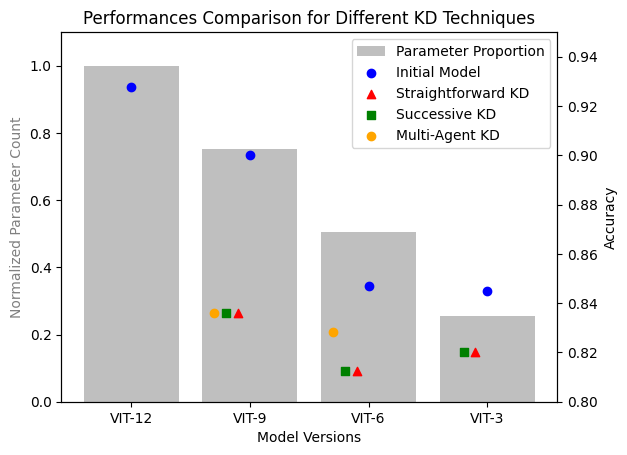

In [43]:
import matplotlib.pyplot as plt
import numpy as np

model_versions = ['VIT-12', 'VIT-9', 'VIT-6', 'VIT-3']
parameters = [85800963, 64537347, 43273731, 22010115] # Number of parameters for each version
raw_accuracies = [0.9375, 0.734375, 0.34375, 0.328125] # Raw accuracies of the models

normalized_parameters = [x / max(parameters) for x in parameters]

kd_accuracies = {
    'Straightforward KD': [0.8359375, 0.8125, 0.8203125],
    'Successive KD': [0.8359375, 0.8125, 0.8203125],
    'Multi-Agent KD': [0.8359375, 0.828125, 0.796875]
}

fig, ax1 = plt.subplots()

bars = ax1.bar(model_versions, normalized_parameters, color='grey', label='Parameter Proportion', alpha=0.5)

initial_model_scatter = ax1.scatter(model_versions, raw_accuracies, color='blue', label='Initial Model')

offset = 0.1
colors = ['red', 'green', 'orange']
shapes = ['^', 's', 'o']
kd_scatters = []

ax2 = ax1.twinx()

for kd_method, (color, shape) in zip(kd_accuracies, zip(colors, shapes)):
    x_positions = np.array(range(len(model_versions))) - offset
    sc = ax2.scatter(x_positions[1:], kd_accuracies[kd_method], color=color, marker=shape, label=kd_method)
    kd_scatters.append(sc)
    offset += 0.1

ax1.set_xlabel('Model Versions')
ax1.set_ylabel('Normalized Parameter Count', color='grey')
ax2.set_ylabel('Accuracy', color='black')
ax1.set_ylim(0, 1.1)
ax2.set_ylim(0.8, 0.95)

handles, labels = [], []
handles.append(bars)
labels.append('Parameter Proportion')
handles.append(initial_model_scatter)
labels.append('Initial Model')
for sc in kd_scatters:
    handles.append(sc)
    labels.append(sc.get_label())

ax2.legend(handles, labels, loc='upper right')

plt.title('Performances Comparison for Different KD Techniques')
plt.show()


In [44]:
import pandas as pd
from IPython.display import display

models = ['VIT-9', 'VIT-6', 'VIT-3']
parameters = [64537347, 43273731, 22010115]
raw_accuracies = [0.734375, 0.34375, 0.328125]
kd_accuracies = {
    'Straightforward KD': [0.8359375, 0.8125, 0.8203125],
    'Successive KD': [0.8359375, 0.8125, 0.8203125],
    'Multi-Agent KD': [0.8359375, 0.828125, 0.796875]
}

df = pd.DataFrame({
    'Model': models,
    'Parameters': parameters,
    'Raw Accuracy': raw_accuracies,
    'Straightforward KD': kd_accuracies['Straightforward KD'],
    'Successive KD': kd_accuracies['Successive KD'],
    'Multi-Agent KD': kd_accuracies['Multi-Agent KD']
})

display(df)


,Model,Parameters,Raw Accuracy,Straightforward KD,Successive KD,Multi-Agent KD
0,VIT-9,64537347,0.734375,0.835938,0.835938,0.835938
1,VIT-6,43273731,0.343750,0.812500,0.812500,0.828125
2,VIT-3,22010115,0.328125,0.820312,0.820312,0.796875
